# EDA of Random Forest Classifier on Machine Failure

## Libraries

In [78]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier


import dtreeviz
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
%matplotlib inline

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.25

## reprocessing

In [12]:
raw_data = pd.read_csv('../machine failure.csv')
data = raw_data.copy()

In [17]:
# if the failure is not a twf, hdf, pwf, or osf then it is treated as a non failure
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)

In [18]:
data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [19]:
clean_dummied_data = pd.get_dummies(data, columns=['Type'])
clean_dummied_data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,1,0


In [22]:
clean_mapped_data = data.copy()
quality_map = {'L': 1, 'M': 2, 'H': 3}
clean_mapped_data['Type'] = clean_mapped_data['Type'].map(quality_map)

In [21]:
clean_dummied_data.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

## Split and Standardize

In [28]:
X = clean_dummied_data.drop(columns='Machine failure')
y = clean_dummied_data['Machine failure']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

In [29]:
X = clean_mapped_data.drop(columns='Machine failure')
y = clean_mapped_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

In [30]:
X_dummy_train

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
9628,299.0,310.0,1569,34.3,132,1,0,0
8271,299.1,310.7,1309,51.1,188,0,1,0
2466,299.0,308.6,1429,37.7,126,0,1,0
3308,301.4,310.4,1433,43.4,86,0,1,0
8134,299.7,311.1,1650,32.4,60,0,1,0
...,...,...,...,...,...,...,...,...
9110,297.6,308.6,1389,49.0,34,0,0,1
5089,303.9,313.1,1483,47.2,71,0,0,1
5904,300.8,310.5,1330,59.0,190,0,0,1
4561,302.9,310.8,1610,32.2,17,0,1,0


In [31]:
scaler = StandardScaler()
X_dummy_train[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.fit_transform(X_dummy_train[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
X_dummy_test[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.transform(X_dummy_test[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])

In [118]:
X_map_train[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.fit_transform(X_map_train[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
X_map_test[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.transform(X_map_test[['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])

## Dummied data

### random forest

In [35]:
model = RandomForestClassifier(random_state=RANDOM_SEED)
model.fit(X_dummy_train, y_dummy_train)

RandomForestClassifier(random_state=42)

### accuracy

In [37]:
def calculate_and_display_accuracy(model, X_train, y_train, X_test, y_test, verbose: bool=True, rounding: int=4) -> list:
    model_train_accuracy = accuracy_score(y_train, model.predict(X_train))
    model_test_accuracy = accuracy_score(y_test, model.predict(X_test))
    baseline_train_accuracy = y_train.value_counts(normalize=True)[0]
    baseline_test_accuracy = y_test.value_counts(normalize=True)[0]
    if verbose:
        print(f'{"Model Training accuracy:":<58} {round(model_train_accuracy, rounding)}')
        print(f'{"Model Test accuracy:":<58} {round(model_test_accuracy, rounding)}')
        print(f'{"Baseline, Naive model (always guess 0) training accuracy:":<58} {round(baseline_train_accuracy, rounding)}')
        print(f'{"Baseline, Naive model (always guess 0) test accuracy:":<58} {round(baseline_test_accuracy, rounding)}')
    return model_train_accuracy, model_test_accuracy, baseline_train_accuracy, baseline_test_accuracy

In [38]:
calculate_and_display_accuracy(model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9999
Model Test accuracy:                                       0.9836
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9998666666666667, 0.9836, 0.9669333333333333, 0.9672)

### SMOTE and ADASYN and TOMEC links

#### SMOTE - 97.3%

In [39]:
smote_resampler = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [40]:
smote_rf = RandomForestClassifier(random_state=RANDOM_SEED)
smote_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [41]:
calculate_and_display_accuracy(smote_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9728
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9728, 0.9669333333333333, 0.9672)

#### ADASYN - 97.4%

In [42]:
adasyn_resampler = ADASYN(random_state=RANDOM_SEED)
X_train_adasyn, y_train_adasyn = adasyn_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [43]:
adasyn_rf = RandomForestClassifier(random_state=RANDOM_SEED)
adasyn_rf.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(random_state=42)

In [44]:
calculate_and_display_accuracy(adasyn_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.974
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.974, 0.9669333333333333, 0.9672)

#### TOMEC links - 98.4%

In [68]:
tomek_resampler = TomekLinks()
X_train_tomek, y_train_tomek = tomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [71]:
tomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
tomek_rf.fit(X_train_tomek, y_train_tomek)

RandomForestClassifier(random_state=42)

In [72]:
calculate_and_display_accuracy(tomek_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9995
Model Test accuracy:                                       0.984
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9994666666666666, 0.984, 0.9669333333333333, 0.9672)

#### SMOTETOMEC links - 97.3%

In [73]:
stomek_resampler = SMOTETomek(random_state=RANDOM_SEED)
X_train_stomek, y_train_stomek = stomek_resampler.fit_resample(X_dummy_train, y_dummy_train)

In [74]:
stomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
stomek_rf.fit(X_train_stomek, y_train_stomek)

RandomForestClassifier(random_state=42)

In [75]:
calculate_and_display_accuracy(stomek_rf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9997
Model Test accuracy:                                       0.9732
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9997333333333334, 0.9732, 0.9669333333333333, 0.9672)

#### balanced rf - 88.1%

In [79]:
clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=3, random_state=RANDOM_SEED)

In [82]:
import warnings
warnings.filterwarnings('ignore')

clf.fit(X_dummy_train, y_dummy_train)
warnings.filterwarnings('default')

In [83]:
calculate_and_display_accuracy(clf, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.8832
Model Test accuracy:                                       0.8812
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.8832, 0.8812, 0.9669333333333333, 0.9672)

## Mapped data

In [119]:
mapped_model = RandomForestClassifier(random_state=RANDOM_SEED)
mapped_model.fit(X_map_train, y_map_train)

RandomForestClassifier(random_state=42)

In [120]:
calculate_and_display_accuracy(mapped_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9848
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9848, 0.9669333333333333, 0.9672)

### SMOTE and ADASYN and TOMEC links

#### SMOTE - 97.4%

In [121]:
smote_resampler = SMOTE(random_state=RANDOM_SEED)
X_map_train_smote, y_map_train_smote = smote_resampler.fit_resample(X_map_train, y_map_train)

In [122]:
smote_rf = RandomForestClassifier(random_state=RANDOM_SEED)
smote_rf.fit(X_map_train_smote, y_map_train_smote)

RandomForestClassifier(random_state=42)

In [123]:
calculate_and_display_accuracy(smote_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9736
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9736, 0.9669333333333333, 0.9672)

#### ADASYN - 97.0%

In [124]:
adasyn_resampler = ADASYN(random_state=RANDOM_SEED)
X_map_train_adasyn, y_map_train_adasyn = adasyn_resampler.fit_resample(X_map_train, y_map_train)

In [125]:
adasyn_rf = RandomForestClassifier(random_state=RANDOM_SEED)
adasyn_rf.fit(X_map_train_adasyn, y_map_train_adasyn)

RandomForestClassifier(random_state=42)

In [126]:
calculate_and_display_accuracy(adasyn_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9696
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(1.0, 0.9696, 0.9669333333333333, 0.9672)

#### TOMEC links - 98.4%

In [127]:
tomek_resampler = TomekLinks()
X_map_train_tomek, y_map_train_tomek = tomek_resampler.fit_resample(X_map_train, y_map_train)

In [128]:
tomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
tomek_rf.fit(X_map_train_tomek, y_map_train_tomek)

RandomForestClassifier(random_state=42)

In [129]:
calculate_and_display_accuracy(tomek_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9993
Model Test accuracy:                                       0.9836
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9993333333333333, 0.9836, 0.9669333333333333, 0.9672)

#### SMOTETOMEC links - 97.4%

In [130]:
stomek_resampler = SMOTETomek(random_state=RANDOM_SEED)
X_map_train_stomek, y_map_train_stomek = stomek_resampler.fit_resample(X_map_train, y_map_train)

In [131]:
stomek_rf = RandomForestClassifier(random_state=RANDOM_SEED)
stomek_rf.fit(X_map_train_stomek, y_map_train_stomek)

RandomForestClassifier(random_state=42)

In [132]:
calculate_and_display_accuracy(stomek_rf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.9996
Model Test accuracy:                                       0.9736
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.9996, 0.9736, 0.9669333333333333, 0.9672)

#### balanced rf - 87.8%

In [133]:
clf = BalancedRandomForestClassifier(
    sampling_strategy="all", replacement=True, max_depth=3, random_state=RANDOM_SEED)

In [134]:
import warnings
warnings.filterwarnings('ignore')

clf.fit(X_map_train, y_map_train)
warnings.filterwarnings('default')

In [135]:
calculate_and_display_accuracy(clf, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   0.8793
Model Test accuracy:                                       0.878
Baseline, Naive model (always guess 0) training accuracy:  0.9669
Baseline, Naive model (always guess 0) test accuracy:      0.9672


(0.8793333333333333, 0.878, 0.9669333333333333, 0.9672)

## Tree Visualization 

In [34]:
adasyn_rf.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

In [40]:
viz_model = dtreeviz.model(model.estimators_[0],
                           X_train=X_train, y_train=y_train,
                           feature_names=X_train_adasyn.columns,
                           target_name='Heat Dissipation Failure', class_names=['No Failure', 'Failure'])

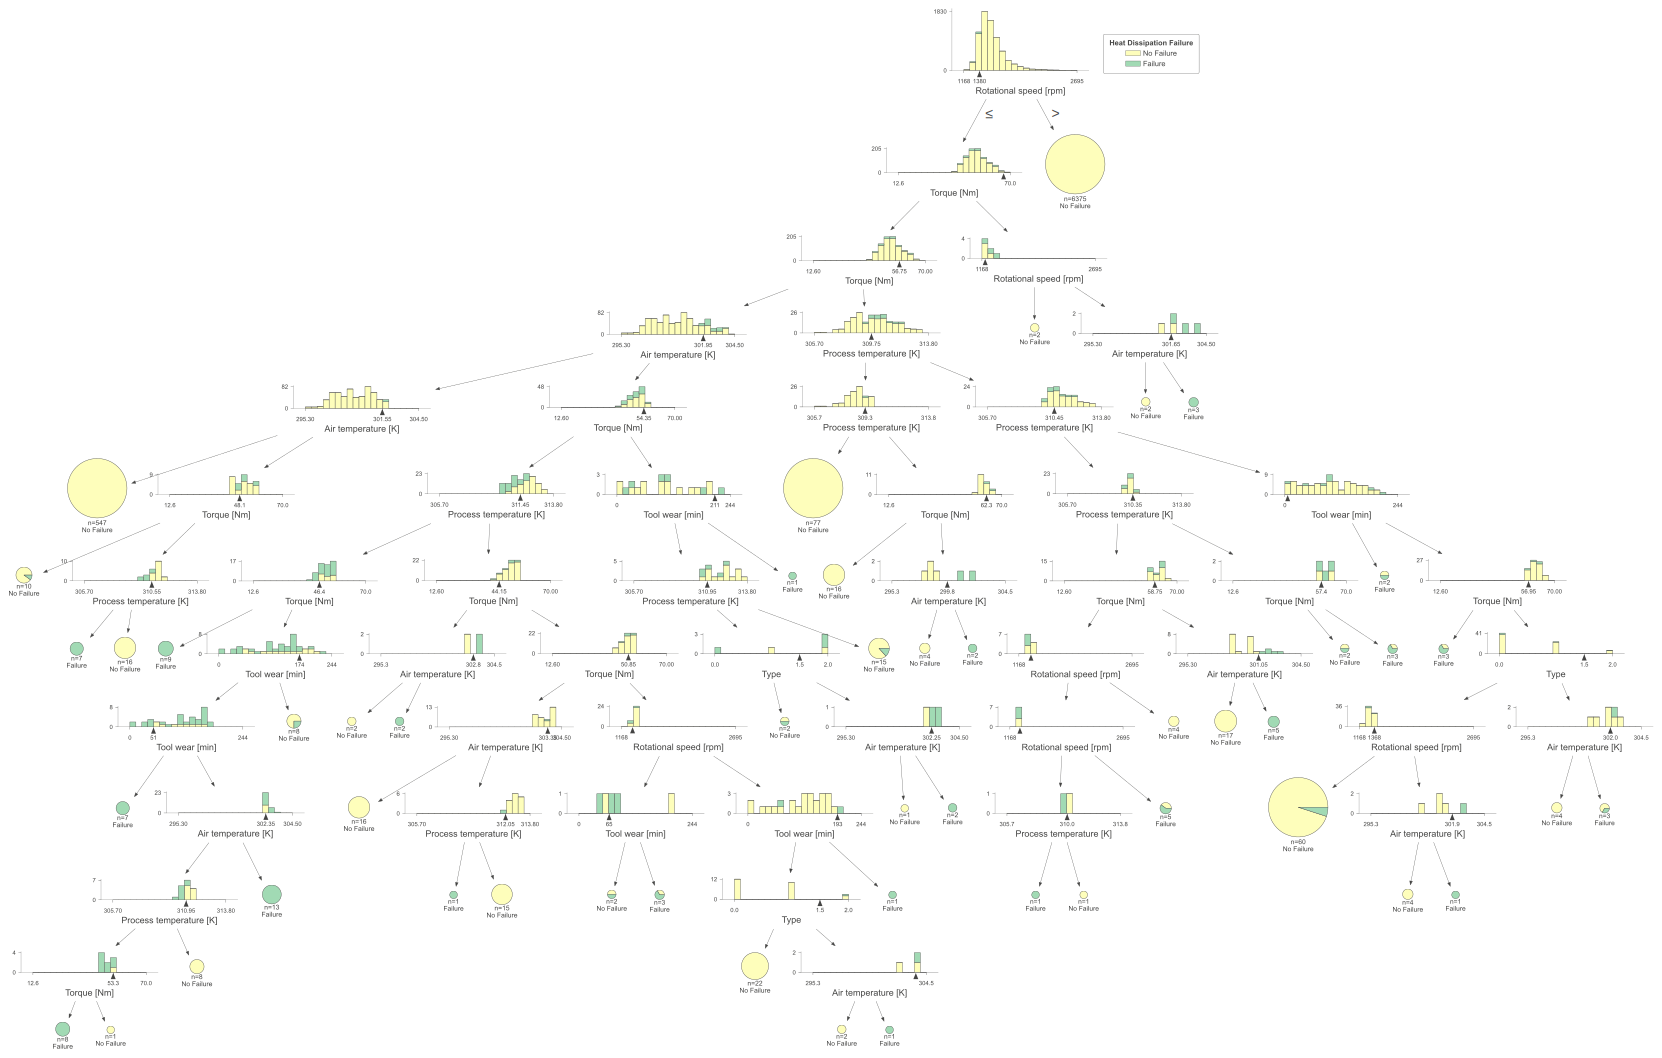

In [41]:
viz_model.view()

## Old exploration and processing

### exploration

In [5]:
df = pd.read_csv('../data/machine_failure.csv', index_col=0)

In [4]:
df.head(2)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [5]:
df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].value_counts()

TWF  HDF  PWF  OSF  RNF
0    0    0    0    0      9652
     1    0    0    0       106
     0    1    0    0        80
          0    1    0        78
1    0    0    0    0        42
0    0    0    0    1        18
          1    1    0        11
     1    0    1    0         6
          1    0    0         3
1    0    0    1    0         2
               0    1         1
          1    1    0         1
dtype: int64

In [8]:
print('---Failures by Type---')
print('twf', 'hdf', 'pwf', 'osf', 'rnf')
print(f"{len(df[df['TWF'] == 1]):<3}", f"{len(df[df['HDF'] == 1]):<3}", f"{len(df[df['PWF'] == 1]):<3}", f"{len(df[df['OSF'] == 1]):<3}", f"{len(df[df['RNF'] == 1]):<3}")


---Failures by Type---
twf hdf pwf osf rnf
46  115 95  98  19 


In [9]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [10]:
a_failure = df[(df['TWF'] == 1) | (df['HDF'] == 1) |  (df['PWF'] == 1) | (df['OSF'] == 1) |  (df['RNF'] == 1)]

In [11]:
a_failure[a_failure['Machine failure'] == 0]

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
1303,L48482,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1
1749,H31162,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1
2073,L49252,L,299.6,309.5,1570,35.5,189,0,0,0,0,0,1
2560,L49739,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1
3066,M17925,M,300.1,309.2,1687,27.7,95,0,0,0,0,0,1
3453,H32866,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1
5472,L52651,L,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
5490,L52669,L,302.6,312.1,1499,35.0,215,0,0,0,0,0,1


### Suggested Filtering Method

In [94]:
# use np.where to plug in ones when HDF is true otherwise 0 for all other failures and non-failures
df['target'] = np.where(df['HDF'] == 1, 1, 0)

In [96]:
df[df['OSF'] == 1].head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,target
UDI,,,,,,,,,,,,,,
70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,0
161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0,0
162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0,0
243,L47422,L,298.0,308.2,1348,58.8,202,1,0,0,0,1,0,0
249,L47428,L,298.0,308.3,1362,56.8,216,1,0,0,0,1,0,0


### preprocessing

In [6]:
# filtered data
# only include HDF positive cases and non-machine failure cases
hdf_df = df[(df['HDF']) | ((df['Machine failure'] == 0) & (df['RNF'] == 0))]

In [7]:
hdf_df['HDF'].value_counts()

0    9643
1     115
Name: HDF, dtype: int64

In [8]:
hdf_df['HDF'].value_counts(normalize=True)

0    0.988215
1    0.011785
Name: HDF, dtype: float64

In [9]:
print('Machine failure with no HDF:', hdf_df[(hdf_df['Machine failure'] == 1) & (hdf_df['HDF'] == 0)].shape[0])
print('No machine failure with HDF:', hdf_df[(hdf_df['Machine failure'] == 0) & (hdf_df['HDF'] == 1)].shape[0])

Machine failure with no HDF: 0
No machine failure with HDF: 0


In [10]:
hdf_df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [11]:
X = hdf_df[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()
X['Type'] = X['Type'].map({'L': 0, 'M': 1, 'H': 2})
X.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
UDI,,,,,,
1,1,298.1,308.6,1551,42.8,0
2,0,298.2,308.7,1408,46.3,3


In [13]:
y = hdf_df['HDF']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)

In [15]:
y_train.value_counts(normalize=True)

0    0.988248
1    0.011752
Name: HDF, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.988115
1    0.011885
Name: HDF, dtype: float64